In [1]:
# Import library
from google.colab import files
from zipfile import ZipFile
import cv2

In [2]:
# Upload Segmentation zip file
uploaded = files.upload()

Saving SegmentationNew (4).zip to SegmentationNew (4).zip


In [3]:
# Specify zip file name
file_name = "SegmentationNew (4).zip"

# Extract dataset
with ZipFile(file_name, 'r') as zip:
    zip.printdir() # Print all files in the zip file
    print('Extracting all files...')
    zip.extractall("LeafSegmentationDisease") # Extracts all files into a new folder
    print('Dataset extracted successfully!')

File Name                                             Modified             Size
Training/                                      2025-12-09 03:18:14            0
Validation/                                    2025-12-09 03:18:16            0
Training/Apple___Apple_scab/                   2025-12-09 03:18:08            0
Training/Apple___Black_rot/                    2025-12-09 03:18:08            0
Training/Apple___Cedar_apple_rust/             2025-12-09 03:18:08            0
Training/Apple___healthy/                      2025-12-09 03:18:08            0
Training/Blueberry___healthy/                  2025-12-09 03:18:08            0
Training/Cherry_(including_sour)___Powdery_mildew/ 2025-12-09 03:18:10            0
Training/Cherry_(including_sour)___healthy/    2025-12-09 03:18:10            0
Training/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/ 2025-12-09 03:18:10            0
Training/Corn_(maize)___Common_rust_/          2025-12-09 03:18:10            0
Training/Corn_(maize)_

In [4]:
import os
# Setting constants
BATCH_SIZE = 32
Image_size = 224
input_shape = (Image_size, Image_size)
dataset_root = "/content/LeafSegmentationDisease"

train_dir = os.path.join(dataset_root, "Training")
test_dir = os.path.join(dataset_root, "Validation")

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

# Define augmentations for train dataset and read the images
train_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.20,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest",
)

# Read data from directory
train_data = train_aug.flow_from_directory(
    train_dir,
    target_size=(Image_size, Image_size),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 1323 images belonging to 38 classes.


In [6]:
# Augmentations for test data
test_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Read data from directory
test_data = test_aug.flow_from_directory(
    test_dir,
    target_size=(Image_size, Image_size),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 570 images belonging to 38 classes.


In [7]:
categories = list(train_data.class_indices.keys())
num_classes = len(categories)
print(f"Total categories: {num_classes}")
print(f"Categories: {categories}")

Total categories: 38
Categories: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, Dropout


# Load the ResNet50 model
resnet_base = tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(Image_size,Image_size,3),
                   weights='imagenet')

resnet_base.trainable=True

for layer in resnet_base.layers[:-50]:
  layer.trainable = False

# Define the input layer for the model
inputs = Input(shape=(Image_size,Image_size,3))
x = resnet_base(inputs, training=False)

# Add custom classification layers
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)


model = Model(inputs, outputs)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,150,054 (92.13 MB)

 Trainable params: 17,512,870 (66.81 MB)

 Non-trainable params: 6,637,184 (25.32 MB)

In [9]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


In [11]:
history = model.fit(
  train_data,
  validation_data=test_data,
  epochs=25,
  callbacks=[early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.0401 - loss: 3.9901 - val_accuracy: 0.1614 - val_loss: 3.2134
Epoch 2/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 491ms/step - accuracy: 0.1239 - loss: 3.2493 - val_accuracy: 0.4667 - val_loss: 2.3276
Epoch 3/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 517ms/step - accuracy: 0.2786 - loss: 2.7263 - val_accuracy: 0.6491 - val_loss: 1.6717
Epoch 4/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 520ms/step - accuracy: 0.3862 - loss: 2.2609 - val_accuracy: 0.7123 - val_loss: 1.1272
Epoch 5/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 531ms/step - accuracy: 0.5229 - loss: 1.7381 - val_accuracy: 0.8000 - val_loss: 0.8472
Epoch 6/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 510ms/step - accuracy: 0.6233 - loss: 1.3204 - val_accuracy: 0.8386 - val_loss: 0.6213
Epoch 7/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 517ms/step - accuracy: 0.6546 - loss: 1.2107 - val_accuracy: 0.8684 - val_loss: 0.5353
Epoch 8/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 530ms/step - accuracy: 0.7478 - loss: 0.8764 - val_accurac

In [ ]:
model.save("LeafDiseaseResNet50.h5")

In [ ]:
from google.colab import files
files.download("/content/LeafDiseaseResNet50.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

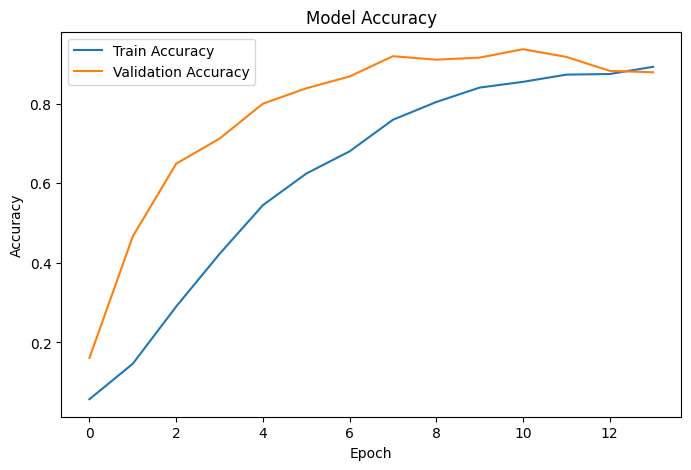

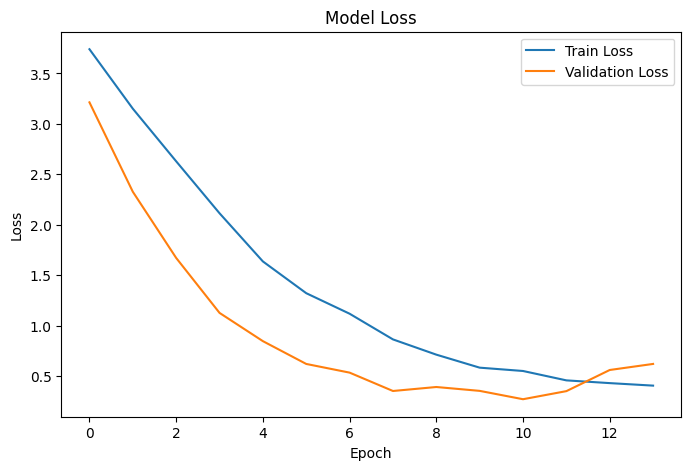

In [12]:
import matplotlib.pyplot as plt

# Accuracy Graph
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss Graph
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
Final Test Accuracy: 0.9368421052631579


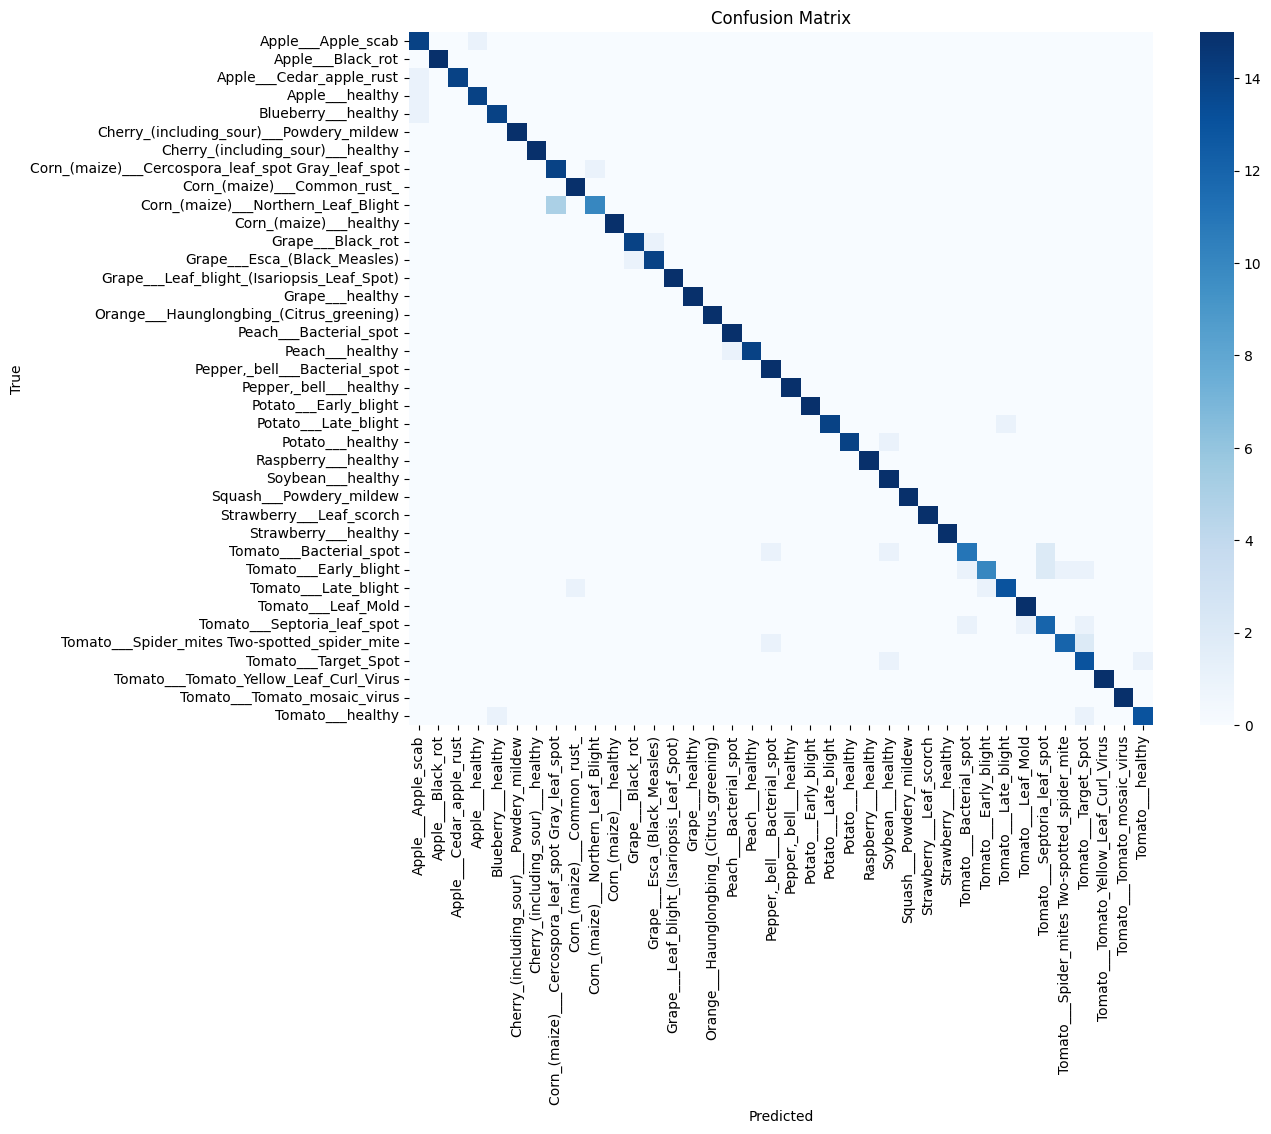

CLASSIFICATION REPORT:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.82      0.93      0.88        15
                                 Apple___Black_rot       1.00      1.00      1.00        15
                          Apple___Cedar_apple_rust       1.00      0.93      0.97        15
                                   Apple___healthy       0.93      0.93      0.93        15
                               Blueberry___healthy       0.93      0.93      0.93        15
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00        15
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00        15
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.74      0.93      0.82        15
                       Corn_(maize)___Common_rust_       0.94      1.00      0.97        15
               Corn_(maize)___Northern_Leaf_Blight      

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

test_data.shuffle = False
test_data.reset()

# Predict test set
y_pred = model.predict(test_data, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_data.classes

# Overall accuracy
print("Final Test Accuracy:",
      np.mean(y_pred_classes == y_true))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12,9))
sns.heatmap(
    cm, annot=False, cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("CLASSIFICATION REPORT:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


Saving 11fd6d2c-f5fe-4128-ba6d-ce0873785493-4cbf7e8 (1).jpg to 11fd6d2c-f5fe-4128-ba6d-ce0873785493-4cbf7e8 (1).jpg
Uploaded image: 11fd6d2c-f5fe-4128-ba6d-ce0873785493-4cbf7e8 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted Class: Squash___Powdery_mildew
Confidence Score: 100.0 %


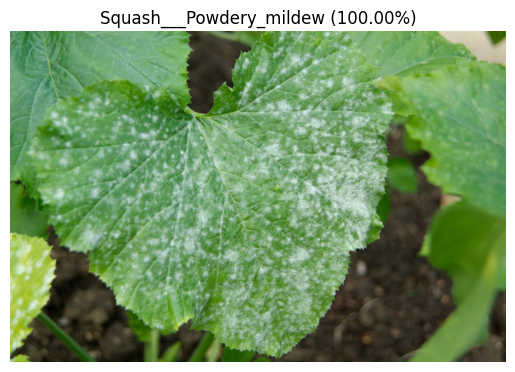

In [35]:
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Upload image
uploaded = files.upload()

# Get uploaded file name
for fn in uploaded.keys():
    test_image_path = fn
    print("Uploaded image:", test_image_path)

# Load and preprocess image
img = load_img(test_image_path, target_size=(Image_size, Image_size))
img_arr = img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)
img_arr = preprocess_input(img_arr)

# Predict
prediction = model.predict(img_arr)
pred_index = np.argmax(prediction)
confidence = np.max(prediction)

# Result
predicted_class = categories[pred_index] # Changed class_names to categories based on notebook state

print("Predicted Class:", predicted_class)
print("Confidence Score:", round(confidence * 100, 2), "%")

# Display Image with title
plt.imshow(load_img(test_image_path))
plt.title(f"{predicted_class} ({confidence*100:.2f}%)")
plt.axis('off')
plt.show()

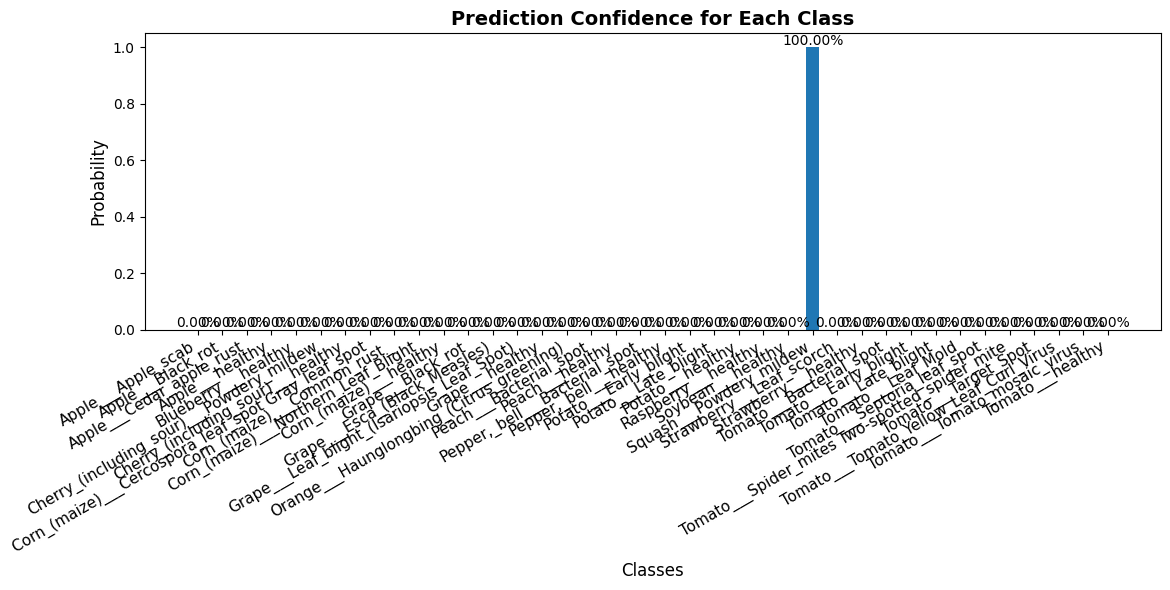

In [36]:
# ======================
# Clean Probability Graph for Uploaded Image
# ======================

probs = prediction[0]  # model output probabilities

plt.figure(figsize=(12,6))
bars = plt.bar(range(len(categories)), probs, width=0.55)

plt.title("Prediction Confidence for Each Class", fontsize=14, fontweight='bold')
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Probability", fontsize=12)

# Fix label overlapping + cleaner visuals
plt.xticks(range(len(categories)), categories, rotation=30, ha='right', fontsize=11)
plt.tight_layout()

# Add values above bars
for i in range(len(categories)):
    plt.text(i, probs[i] + 0.01, f"{probs[i]*100:.2f}%",
             ha='center', fontsize=10)

plt.show()
